## 使用Fashion-MINIST数据集
### 读取数据集

In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

In [2]:
from matplotlib import pyplot as plt

def get_fashion_mnist_labels(labels):
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot'
    ]
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

torch.Size([18, 1, 28, 28])


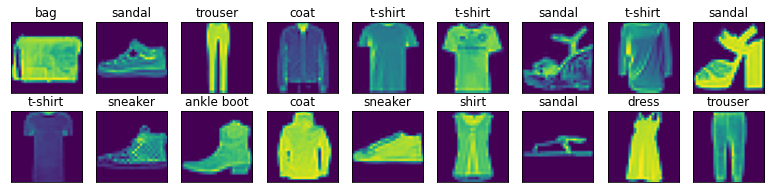

In [3]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=".", train=True, transform=trans, download=False)
    mnist_test  = torchvision.datasets.FashionMNIST(root=".", train=False,transform=trans, download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4),
                 data.DataLoader(mnist_test,  batch_size, shuffle=True, num_workers=4))

train_iter, test_iter = load_data_fashion_mnist(18)
#show_images(next(train_iter)[0], 2, 9, titles=get_fashion_mnist_labels(next(train_iter)[1]))
for X, y in train_iter:
    print(X.shape)
    show_images(X.reshape(18,28,28), 2, 9, titles=get_fashion_mnist_labels(y))
    break

## 从零实现softmax回归
实现softmax模型，并且对Fashion-MNIST数据集进行训练并测试。
在此回归中，输出类有10个类中，因此网络的输出维度也是10。原始数据中的每个样本都是28\*28的图像，所以权重是一个784x10的矩阵，bias是1x10的向量。

与线性回归一样，首先使用正态分布初始化权重，bias初始化为0

In [4]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

num_inputs = 784 # the num of features
num_outputs= 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [5]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(dim=1, keepdims=True)
    return X_exp/partition

def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)


实现交叉熵函数：

In [6]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

计算分类准确率，使用argmax获得每行最大元素的索引来获得预测的类别, 统计预测类别正确的个数

In [7]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

评估在整个数据集上的准确率：

In [8]:
class Accumulator:  #@save
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [9]:
evaluate_accuracy(net, test_iter)

0.1098

In [ ]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for p in params:
            p -= lr * p.grad / batch_size # 梯度下降
            p.grad.zero_() # clear grad
            
            
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
        
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                    float(l) * len(y), accuracy(y_hat, y),
                    y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
    train_loss, train_acc = train_metrics

lr = 0.01
def updater(batch_size):
    return sgd([W,b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [ ]:
def predict_ch3(net, test_iter, n=6):
    for X,y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + ',' + pred for true, pred in zip(trues, preds)]
    return trues, preds
    
t, p = predict_ch3(net, test_iter)
wrong = 0
for i, j in zip(t, p):
    if i != j:
        wrong += 1

In [ ]:
print(wrong)
print(1-wrong/256)